In [1]:
# TODO:
# - test UNet
# - Implement dataloader
#     - three channel lrb split
# - discriminator
# - Train
#     - set checkpoint
# - Dataset

# done
# - Unet


In [18]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
import glob
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
from tqdm import tqdm

print("Device name", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Training in', device, '...')

True
device name NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [9]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        
        return x

In [4]:
class DownUnit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.maxpool = nn.MaxPool2d(2)
        self.doubleconv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        return self.doubleconv(self.maxpool(x))

In [5]:
class UpUnit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.doubleconv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x, y):
        x = self.up(x)
        x = torch.cat([x, y], 1)  # the dim might create some issues later
        x = self.doubleconv(x)
        
        return x

In [6]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.input = DoubleConv(in_channels, 16)
        self.down1 = DownUnit(16, 32)
        self.down2 = DownUnit(32, 64)
        self.down3 = DownUnit(64, 128)
        self.down4 = DownUnit(128, 256)
        
        self.up1 = UpUnit(256, 128)
        self.up2 = UpUnit(128, 64)
        self.up3 = UpUnit(64, 32)
        self.up4 = UpUnit(32, 16)
        self.out = OutConv(16, out_channels)
    
    def forward(self, x):
        
        x1 = self.input(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x6 = self.up1(x5, x4)
        x7 = self.up2(x6, x3)
        x8 = self.up3(x7, x2)
        x9 = self.up4(x8, x1)
        
        return self.out(x9)

In [10]:
model = UNet(3, 1)
model = model.to(device)

Training in cuda ...


In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, folder_path):
        
        folder_path = os.path.normpath(folder_path)
        self.images_path = glob.glob(folder_path + '/*')

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        
        image = Image.open(self.images_path[idx])
        label = image.copy().convert('L')
        
        image, label = self.prepare(image), self.prepare(label, True)
        
        return [image, label]
        
    def prepare(self, image, add_dim=False):
        
        image = np.asarray(image)
        
        if add_dim:
            image = np.expand_dims(image, 2)
        
        image = image / 255.0
        image = torch.from_numpy(image).float()
        image = image.permute(2, 0, 1)
        image = F.resize(image, size=[256, 256])
        
        return image

dataset = CustomImageDataset('./dataset')
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# for i, im in enumerate(data_loader):
#     print(f'batch {i+1}: {type(im), len(im)}')
    
#     for idx in range(len(im)): 
#         print(f'{len(im[idx])} {im[idx].shape}')

batch 1: (<class 'list'>, 2)
aaa 2 torch.Size([2, 3, 256, 256])
aaa 2 torch.Size([2, 1, 256, 256])
batch 2: (<class 'list'>, 2)
aaa 2 torch.Size([2, 3, 256, 256])
aaa 2 torch.Size([2, 1, 256, 256])
batch 3: (<class 'list'>, 2)
aaa 2 torch.Size([2, 3, 256, 256])
aaa 2 torch.Size([2, 1, 256, 256])


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [15]:
EPOCHS = 200

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    
    b='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}{postfix}]'
    pbar = tqdm(total=len(data_loader), bar_format=b,
                desc=f'Epochs: {epoch+1}/{EPOCHS}')
    
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        pbar.update(1)
        pbar.set_postfix(Loss=f'{(loss/len(data)):.4f}')
    pbar.close()

Epochs: 67/200: 100%|███████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, Loss=0.0046]


Epochs: 134/200: 100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, Loss=0.0004]


Epochs: 200/200: 100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, Loss=0.0002]

Finished Training


Sample: 1


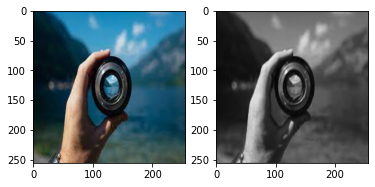

Sample: 2


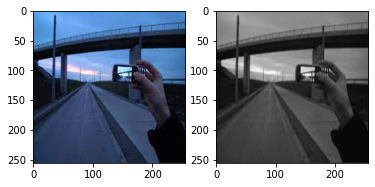

Sample: 3


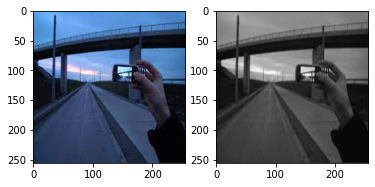

In [25]:
model.eval()

def test_random_images(model, folder_path, samples):
    
    image_paths = glob.glob(folder_path + '/*')
    
    for i in range(samples):
        
        print(f'Sample: {i+1}')
        
        idx = random.randint(0, len(image_paths)-1)
        
        image = Image.open(image_paths[idx])
        image = image.resize((256, 256))
        image = np.asarray(image) / 255.0
        
        image_torch = torch.from_numpy(image)
        image_torch = image_torch.permute(2, 0, 1)
        image_torch = torch.unsqueeze(image_torch, 0).float()
        image_torch = image_torch.to(device)
        
        out_torch = model(image_torch)
        
        out_torch = out_torch.squeeze(0).squeeze(0)
        out = out_torch.cpu().detach().numpy()
        
        plt.figure(1)
        plt.subplot(121)
        plt.imshow(image)
        
        plt.subplot(122)
        plt.imshow(out, cmap='gray')
        
        plt.show()
        
test_random_images(model, './dataset', 3)